In [1]:
import pprint
import pandas as pd
import numpy as np
import pickle
import dask
import dask.dataframe as dd
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
%matplotlib inline
# from fbprophet import Prophet

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 6

import itertools
import seaborn as sns
from multiprocessing import Pool
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import fbprophet
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# display only 15 rows of results at maximum in each cell
# display all columns in each cell
pd.options.display.max_rows = 15
pd.set_option('display.max_columns', 50)

In [3]:
# load dataframe with only transaction records for Targets
with open ('df_target.pickle','rb') as f:
    df_target = pickle.load(f)

In [4]:
df_target.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year_Week,Year_Quarter,Year,Markup Per Bottle,Markup Per Transaction,Cost Per Transaction,Markup Rate Per Item,Shortened Store Name
Year_Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01,S03394800002,2012-01-03,3880,Target,3804 METRO DR,COUNCIL BLUFFS,51503,POINT (-95.837595 41.220979),78,pottawattamie,1011200,STRAIGHT BOURBON WHISKIES,65,Jim Beam Brands,19476,Maker's Mark,12,750.0,15.74,23.61,12.0,283.32,9.0,2.38,2012-01-02/2012-01-08,2012Q1,2012,7.87,94.44,188.88,50.00,Targ
2012-01,S03393700006,2012-01-03,3872,Target,3500 DODGE ST,DUBUQUE,52003,POINT (-90.720589 42.491944),31,dubuque,1022100,TEQUILA,410,The Patron Spirits Company,88294,Patron Silver Tequila,12,375.0,13.33,20.00,12.0,240.00,4.5,1.19,2012-01-02/2012-01-08,2012Q1,2012,6.67,80.04,159.96,50.04,Targ
2012-01,S03394800006,2012-01-03,3880,Target,3804 METRO DR,COUNCIL BLUFFS,51503,POINT (-95.837595 41.220979),78,pottawattamie,1062300,FLAVORED RUM,370,Pernod Ricard USA/Austin Nichols,42716,Malibu Coconut Rum,12,750.0,6.90,10.35,12.0,124.20,9.0,2.38,2012-01-02/2012-01-08,2012Q1,2012,3.45,41.40,82.80,50.00,Targ
2012-01,S03393700008,2012-01-03,3872,Target,3500 DODGE ST,DUBUQUE,52003,POINT (-90.720589 42.491944),31,dubuque,1071100,AMERICAN COCKTAILS,65,Jim Beam Brands,63355,Skinnygirl Margarita,12,750.0,7.69,11.53,12.0,138.36,9.0,2.38,2012-01-02/2012-01-08,2012Q1,2012,3.84,46.08,92.28,49.93,Targ
2012-01,S03393700002,2012-01-03,3872,Target,3500 DODGE ST,DUBUQUE,52003,POINT (-90.720589 42.491944),31,dubuque,1011300,TENNESSEE WHISKIES,85,Brown-Forman Corporation,26826,Jack Daniels Old #7 Black Lbl,12,750.0,13.01,19.51,12.0,234.12,9.0,2.38,2012-01-02/2012-01-08,2012Q1,2012,6.50,78.00,156.12,49.96,Targ


# <font color='orange'>Sales Prediction for Target Stores</font>
Take the Target stores for example to build fbprophet model for predicting potention sales/markup for the next 12 months. Business case would be predicting revenue/markup generated from each retail store brand with potential taxes collected.

In [5]:
# group all the columns by month for Target Store dataframe
monthly_target = df_target.groupby(['Year_Month']).sum() #dataframe for time series analysis for Fareway
monthly_target.index = monthly_target.index.to_timestamp()
monthly_target.reset_index(inplace=True)
monthly_target.head()

,Year_Month,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Markup Per Bottle,Markup Per Transaction,Cost Per Transaction,Markup Rate Per Item
0,2012-01-01,3325770,8144,1010925.0,9227.11,13893.90,8645.0,127020.75,9235.95,2439.97,4666.79,42739.53,84281.22,44939.53
1,2012-02-01,3821565,9352,1149975.0,11109.98,16717.18,10031.0,152527.12,10141.77,2679.50,5607.20,51134.50,101392.62,51328.49
2,2012-03-01,3823878,9230,1187150.0,10732.28,16141.07,9882.0,144364.93,10443.34,2759.07,5408.79,48389.71,95975.22,51365.09
3,2012-04-01,3951266,9640,1221500.0,11108.29,16750.01,10731.0,156640.50,11601.99,3065.11,5641.72,52770.97,103869.53,53395.62
4,2012-05-01,4916521,12186,1452900.0,13590.67,20450.31,13590.0,195673.52,13536.10,3576.29,6859.64,65611.98,130061.54,66217.85


In [6]:
# create a dataframe with only month indices and monthly sales for fbprophet forcasting
# rename column names for fitting fbprophet model
monthly_target_ph = monthly_target[['Year_Month','Sale (Dollars)']]
monthly_target_ph = monthly_target_ph.rename(columns={'Year_Month': 'ds', 'Sale (Dollars)': 'y'})
monthly_target_ph.head()

,ds,y
0,2012-01-01,127020.75
1,2012-02-01,152527.12
2,2012-03-01,144364.93
3,2012-04-01,156640.50
4,2012-05-01,195673.52


## Prophet Model for Predicting Sales (Using Target Stores as Example)

### <font color='red'>Train-Test Split for Prophet</font>

In [7]:
def train_test_split(df):
    '''return 80-12 train-test split data'''
    size = int(80)
    train, test = df[0:size], df[size:len(df)]
    print('Train:', len(train))
    print('Test:', len(test))
    return train, test

In [8]:
# create 80 - 12 train-validation-test data
# since we want to predict the future 12 months sales, so we set test set as 12
# print out the lenth of train, validation,and test data
target_ph_train, target_ph_test = train_test_split(monthly_target_ph)

Train: 80
Test: 12


### <font color='red'>Train Prophet Model</font>

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


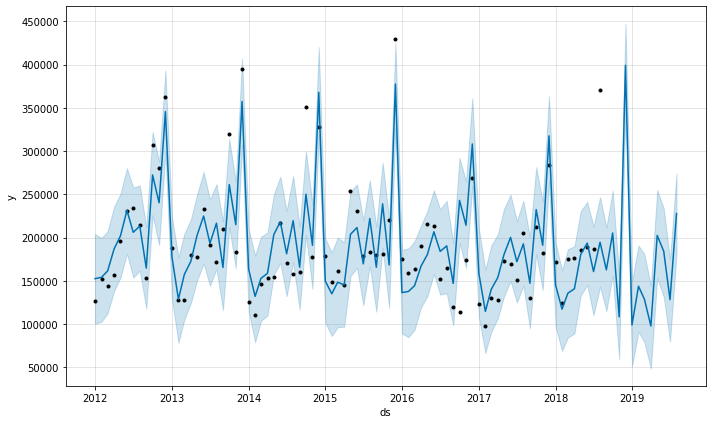

In [9]:
# train fbprophet model on training set and predict on test set
# see the last dot (August 2019) is very off from the true value
m = Prophet(seasonality_mode='multiplicative').fit(target_ph_train)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)

### <font color='red'>Validate Prophet Model</font>
Predict monthly sales on test set, then validate the predicted results against the true values from test set. <br>
Error scores/performance metrics used are MAE, MAPE, and RMSE.

In [10]:
# see the predicted results (tail 12 predicted/yhat values against the true values from test set)
fcst.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
80,2018-08-31,176458.038453,115158.131379,211683.263572,176458.032692,176458.044390,-0.077925,-0.077925,-0.077925,-0.077925,-0.077925,-0.077925,0.0,0.0,0.0,162707.602238
81,2018-09-30,175994.688980,156274.514108,254157.448805,175994.649970,175994.722717,0.166779,0.166779,0.166779,0.166779,0.166779,0.166779,0.0,0.0,0.0,205346.904137
82,2018-10-31,175515.894525,59888.407501,156630.828399,175515.815725,175515.970595,-0.382365,-0.382365,-0.382365,-0.382365,-0.382365,-0.382365,0.0,0.0,0.0,108404.688395
83,2018-11-30,175052.545052,350535.230969,447224.429200,175052.406081,175052.682729,1.279798,1.279798,1.279798,1.279798,1.279798,1.279798,0.0,0.0,0.0,399084.365574
84,2018-12-31,174573.750597,51271.124470,149367.752893,174573.525712,174573.960043,-0.432215,-0.432215,-0.432215,-0.432215,-0.432215,-0.432215,0.0,0.0,0.0,99120.351162
85,2019-01-31,174094.956141,91268.774905,190776.447287,174094.668025,174095.250682,-0.173753,-0.173753,-0.173753,-0.173753,-0.173753,-0.173753,0.0,0.0,0.0,143845.508016
86,2019-02-28,173662.496633,78947.376491,180845.475101,173662.135028,173662.883379,-0.257820,-0.257820,-0.257820,-0.257820,-0.257820,-0.257820,0.0,0.0,0.0,128888.917027
87,2019-03-31,173183.702178,48681.036111,144270.494458,173183.237678,173184.179927,-0.434936,-0.434936,-0.434936,-0.434936,-0.434936,-0.434936,0.0,0.0,0.0,97859.874076
88,2019-04-30,172720.352705,153372.899615,254969.685381,172719.791146,172720.896954,0.172246,0.172246,0.172246,0.172246,0.172246,0.172246,0.0,0.0,0.0,202470.666328
89,2019-05-31,172241.558249,131529.801389,234039.657342,172240.886669,172242.203847,0.070067,0.070067,0.070067,0.070067,0.070067,0.070067,0.0,0.0,0.0,184310.071736


In [11]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2012-01-01,214112.347649,100264.835809,204071.992813,214112.347649,214112.347649,-0.287473,-0.287473,-0.287473,-0.287473,-0.287473,-0.287473,0.0,0.0,0.0,152560.900559
1,2012-02-01,213632.483411,102846.637538,199579.609529,213632.483411,213632.483411,-0.278671,-0.278671,-0.278671,-0.278671,-0.278671,-0.278671,0.0,0.0,0.0,154099.405758
2,2012-03-01,213183.578156,112619.474227,207467.274356,213183.578156,213183.578156,-0.242406,-0.242406,-0.242406,-0.242406,-0.242406,-0.242406,0.0,0.0,0.0,161506.634471
3,2012-04-01,212703.713918,138324.541426,235787.327187,212703.713918,212703.713918,-0.120751,-0.120751,-0.120751,-0.120751,-0.120751,-0.120751,0.0,0.0,0.0,187019.469470
4,2012-05-01,212239.329183,153715.013183,250660.590261,212239.329183,212239.329183,-0.048557,-0.048557,-0.048557,-0.048557,-0.048557,-0.048557,0.0,0.0,0.0,201933.636953
5,2012-06-01,211759.464957,181403.713600,280236.717611,211759.464957,211759.464957,0.092943,0.092943,0.092943,0.092943,0.092943,0.092943,0.0,0.0,0.0,231440.966575
6,2012-07-01,211295.080217,153809.129576,257762.039054,211295.080217,211295.080217,-0.024630,-0.024630,-0.024630,-0.024630,-0.024630,-0.024630,0.0,0.0,0.0,206090.916042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-01-31,174094.956141,91268.774905,190776.447287,174094.668025,174095.250682,-0.173753,-0.173753,-0.173753,-0.173753,-0.173753,-0.173753,0.0,0.0,0.0,143845.508016
86,2019-02-28,173662.496633,78947.376491,180845.475101,173662.135028,173662.883379,-0.257820,-0.257820,-0.257820,-0.257820,-0.257820,-0.257820,0.0,0.0,0.0,128888.917027


In [12]:
# my test set
target_ph_test

,ds,y
80,2018-09-01,222144.96
81,2018-10-01,190894.86
82,2018-11-01,294859.10
83,2018-12-01,490935.74
84,2019-01-01,215846.96
85,2019-02-01,167960.04
86,2019-03-01,183671.92
87,2019-04-01,166733.76
88,2019-05-01,213249.48
89,2019-06-01,249083.64


In [13]:
# note: need to figure out why the predicted results got one day shifted ahead
# prepare for true y value and yhat value from prediction to calculate the error metrics
# metric_df = fcst[-12:].set_index('ds')[['yhat']].join(target_ph_test.set_index('ds').y).reset_index()
# validate if the metric_df was set up correctly
metric_df = pd.concat((fcst[-12:][['yhat']], pd.DataFrame(target_ph_test['y'])), axis = 1)
metric_df

,yhat,y
80,162707.602238,222144.96
81,205346.904137,190894.86
82,108404.688395,294859.10
83,399084.365574,490935.74
84,99120.351162,215846.96
85,143845.508016,167960.04
86,128888.917027,183671.92
87,97859.874076,166733.76
88,202470.666328,213249.48
89,184310.071736,249083.64


In [14]:
# define function to calculate error scores/performance metrics
def error_scores(metric_df):
    mae = mean_absolute_error(metric_df.y, metric_df.yhat)
    mape = np.mean(np.abs(np.array(metric_df.yhat) - np.array(metric_df.y))/np.abs(np.array(metric_df.y))) 
    rmse = np.mean((np.array(metric_df.yhat) - np.array(metric_df.y))**2)**.5
    return mae, mape, rmse

In [15]:
# return the error scores
# will later compare with the error scores from my own SARIMA model
error_scores(metric_df)

(68796.60692904261, 0.2863488267223234, 84815.69792706841)

### <font color='red'>Forecast Sales for The Next 12 Months with Prophet Model</font>
Use prophet model to Predict Sales for The Next 12 Months for Target Stores

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


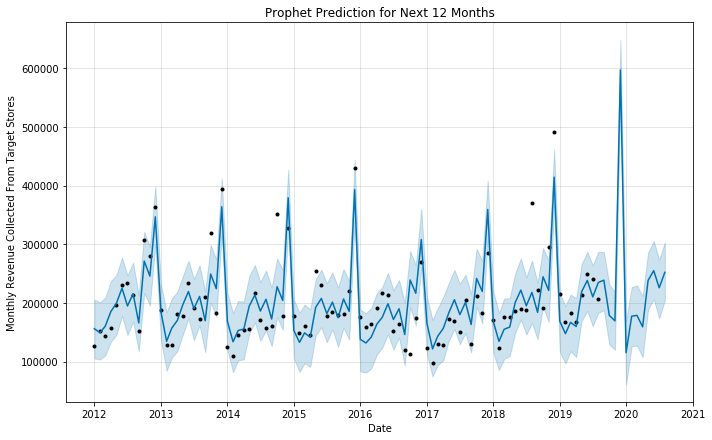

In [16]:
fbprophet.plot.plot_plotly
# train model on the whole monthly target prophet set, then predict the future values for the next 12 months
# out of time prediction
# will be compared with the predicted values from my own SARIMA model later
m = Prophet(seasonality_mode='multiplicative').fit(monthly_target_ph)
future = m.make_future_dataframe(periods=12, freq='M')
fcst_future = m.predict(future)
fig = m.plot(fcst_future, xlabel = 'Date', ylabel = 'Monthly Revenue Collected From Target Stores')

plt.title('Prophet Prediction for Next 12 Months')
fig.savefig('Prophet Prediction for Next 12 Months.png', bbox_inches="tight",format='png',dpi=200)

In [17]:
# show the predicted results for the next 12 months since August 2019
sales_2019_Sep_2020_Aug = pd.DataFrame(fcst_future[-12:][['yhat']])
sales_2019_Sep_2020_Aug = pd.concat((sales_2019_Sep_2020_Aug, future[-12:]),axis = 1)
sales_2019_Sep_2020_Aug = sales_2019_Sep_2020_Aug.rename(columns={'yhat': 'Predicted Monthly Sale','ds':'Future Dates'})
sales_2019_Sep_2020_Aug .set_index('Future Dates', inplace=True)

In [18]:
sales_2019_Sep_2020_Aug

,Predicted Monthly Sale
Future Dates,
2019-08-31,238747.593939
2019-09-30,178720.959745
2019-10-31,169439.473708
2019-11-30,596852.198535
2019-12-31,115259.151105
2020-01-31,177428.370186
2020-02-29,178782.286891
2020-03-31,159323.368366
2020-04-30,238304.181151


### <font color='red'>Pickle Dataframes for Consolidating Analysis</font>

In [19]:
# pickle all 12 predicted monthly sales for future visualization
prophet_sales_2019_Sep_2020_Aug = sales_2019_Sep_2020_Aug.to_pickle('prophet_sales_2019_Sep_2020_Aug.pickle')

### <font color='red'>Time Series Visualization with Plotly</font>

In [20]:
!pip install chart-studio

In [21]:
# import plotly.plotly as py
import plotly.graph_objs as go
import chart_studio as cs
import chart_studio.plotly as py

In [22]:
# append the true value for the whole dataset
# should have 92 true values added since the remaining 12 records are predicted for the next 12 months
fcst_future['actual'] = monthly_target_ph['y']
fcst_future.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,actual
0,2012-01-01,212896.032786,105348.621661,205753.902763,212896.032786,212896.032786,-0.266581,-0.266581,-0.266581,-0.266581,-0.266581,-0.266581,0.0,0.0,0.0,156142.063484,127020.75
1,2012-02-01,212370.129915,103769.318677,200926.644560,212370.129915,212370.129915,-0.297345,-0.297345,-0.297345,-0.297345,-0.297345,-0.297345,0.0,0.0,0.0,149223.030533,152527.12
2,2012-03-01,211878.156261,110599.065874,209338.712245,211878.156261,211878.156261,-0.242866,-0.242866,-0.242866,-0.242866,-0.242866,-0.242866,0.0,0.0,0.0,160420.256921,144364.93
3,2012-04-01,211352.253389,133779.394538,237245.300356,211352.253389,211352.253389,-0.121957,-0.121957,-0.121957,-0.121957,-0.121957,-0.121957,0.0,0.0,0.0,185576.324538,156640.50
4,2012-05-01,210843.315127,145796.884978,247087.277943,210843.315127,210843.315127,-0.055614,-0.055614,-0.055614,-0.055614,-0.055614,-0.055614,0.0,0.0,0.0,199117.496207,195673.52


In [28]:
# load the predicted values with sarima and prophet models
with open ('sarima_result_df.pickle','rb') as f:
    sarima_result = pickle.load(f)
    
with open ('prophet_result_df.pickle','rb') as f:
    prophet_result = pickle.load(f)

In [56]:
# plot the time series(predicted vs actual) with rangeslider
trace_1 = go.Scatter(
    x=prophet_result.index,
    y=prophet_result['Prophet Prediction'],
    name = 'Prophet Prediction',
    line = dict(color = '#ff7f0e'),
    opacity = 0.8)

trace_2 = go.Scatter(
    x=sarima_result.index,
    y=sarima_result['Sarima Prediction'],
    name = 'Sarima Prediction',
    line = dict(color = '#1f77b4'),
    opacity = 0.8)

trace_3 = go.Scatter(
    x=fcst_future.ds,
    y=fcst_future['actual'],
    name = 'Actual Monthly Revenue',
    line = dict(color = '#17BECF'),
    opacity = 0.8)

data = [trace_1, trace_2, trace_3]

layout = dict(
    title='Monthly Revenue Collected From Target Stores',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.sign_in('whereisfluffy89', 'iZkP3OHYZiRQ2qFVkQyX')
py.iplot(fig, filename = "Predicted Monthly Revenue Collected From Target Stores")